In [1]:
%load_ext autoreload
%autoreload 2

# Import packages

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
from moscot import FusedGW
from ott.geometry.geometry import Geometry
from jax import numpy as jnp

Note that `ot` stands for POT. 

In [4]:
import matplotlib.pyplot as pl
import numpy as np
import ot
from ot.gromov import fused_gromov_wasserstein, entropic_gromov_wasserstein, gromov_wasserstein

Data simulation

In [5]:
# taken from: https://pythonot.github.io/auto_examples/gromov/plot_fgw.html#sphx-glr-auto-examples-plot-fgw-py
n = 20  # number of points in the first distribution
n2 = 30  # number of points in the second distribution
sig = 1  # std of first distribution
sig2 = 0.1  # std of second distribution

np.random.seed(0)

# source data (s)
phi = np.arange(n)[:, None]
xs = phi + sig * np.random.randn(n, 1)
ys = np.vstack((np.ones((n // 2, 1)), 0 * np.ones((n // 2, 1)))) + sig2 * np.random.randn(n, 1)

# target data (t)
phi2 = np.arange(n2)[:, None]
xt = phi2 + sig * np.random.randn(n2, 1)
yt = np.vstack((np.ones((n2 // 2, 1)), 0 * np.ones((n2 // 2, 1)))) + sig2 * np.random.randn(n2, 1)
yt = yt[::-1, :]

p = ot.unif(n)
q = ot.unif(n2)

# Visualize the data

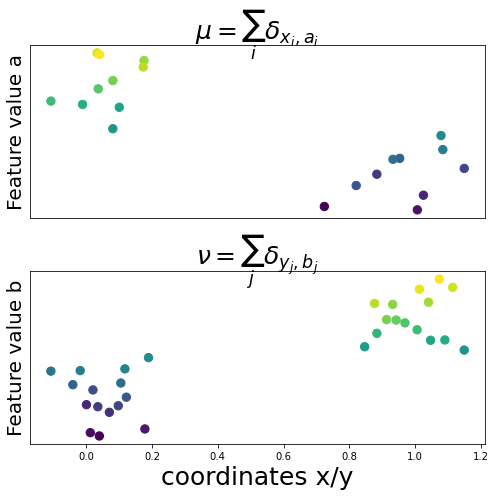

In [6]:
pl.close(10)
pl.figure(10, (7, 7))

pl.subplot(2, 1, 1)

pl.scatter(ys, xs, c=phi, s=70)
pl.ylabel('Feature value a', fontsize=20)
pl.title('$\mu=\sum_i \delta_{x_i,a_i}$', fontsize=25, y=1)
pl.xticks(())
pl.yticks(())

pl.subplot(2, 1, 2)

pl.scatter(yt, xt, c=phi2, s=70)
pl.xlabel('coordinates x/y', fontsize=25)
pl.ylabel('Feature value b', fontsize=20)
pl.title('$\\nu=\sum_j \delta_{y_j,b_j}$', fontsize=25, y=1)
pl.yticks(())

pl.tight_layout()
pl.show()

So we have a structure space, given by x and y, which is specific to each space. Also, we have a feature space which is shared. The featrue space is shown on the y-axis, and the color is just the y-value. 

# Run FGW

In [7]:
alpha = 0.5
epsilon = 1e-1

# build structure matrices on the x-coordinates
C1 = ot.dist(xs)
C2 = ot.dist(xt)

# build feature matrix on y-coordinates (shared between both spaces. )
M = ot.dist(ys, yt)

# uniform marginals
w1 = ot.unif(C1.shape[0])
w2 = ot.unif(C2.shape[0])

## moscot

In [31]:
C1_g = Geometry(cost_matrix=jnp.asarray(C1))
C2_g = Geometry(cost_matrix=jnp.asarray(C2))
M_g = Geometry(cost_matrix=jnp.asarray(M))

fgwot = FusedGW(alpha=alpha, epsilon=epsilon)
fgwot.fit(C1_g, C2_g, M_g, log=True, n_iters=20, tol=1e-9, novosparc=True)

1. err=0.18755851160384346 tau=0
2. err=0.23508658543199668 tau=0
3. err=0.24425619179628177 tau=0
4. err=0.20884980094076092 tau=0
5. err=0.16147197496887403 tau=0
6. err=0.13588642133975506 tau=0
7. err=0.12685844675220423 tau=0
8. err=0.0004945326330418638 tau=0
9. err=1.9259156862176867e-07 tau=0
10. err=7.688881737483808e-11 tau=0


Text(0, 0.5, 'i')

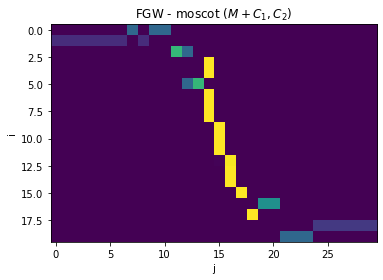

In [9]:
pl.imshow(fgwot.matrix, cmap='viridis', interpolation='nearest')
pl.title('FGW - moscot ($M+C_1,C_2$)')
pl.xlabel('j')
pl.ylabel('i')

## POT

In [32]:
Gwg, logw = fused_gromov_wasserstein(M, C1, C2, p, q, loss_fun='square_loss',
                                     armijo=True,
                                     alpha=alpha, verbose=True, log=True)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.342014e+04|0.000000e+00|0.000000e+00
    1|1.973562e+04|1.866940e-01|3.684523e+03
    2|1.106805e+04|7.831158e-01|8.667568e+03
    3|1.091677e+04|1.385788e-02|1.512833e+02
    4|1.091525e+04|1.391900e-04|1.519294e+00
    5|1.091524e+04|1.391961e-06|1.519359e-02
    6|1.091524e+04|1.391962e-08|1.519359e-04
    7|1.091524e+04|1.391961e-10|1.519358e-06


Text(0.5, 0, 'j')

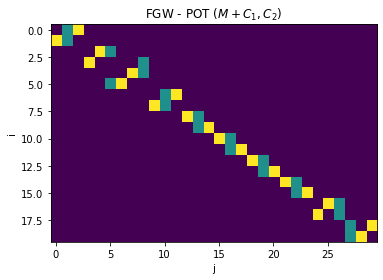

In [11]:
pl.imshow(Gwg, cmap='viridis', interpolation='nearest')
pl.title('FGW - POT ($M+C_1,C_2$)')
pl.ylabel('i')
pl.xlabel('j')

## Compare with paper results

The figure below is from [Vayer et al., Algorithms 2020](https://hal.archives-ouvertes.fr/hal-02971153)

![Fig. 10](fig_10.png "Title")

# Compare with pure (reg.) Wasserstein loss

\alpha = 0 should correspond to entropically regularized optimal transport. 

In [11]:
coupling_ot, loss_ot = ot.sinkhorn(p, q, M, reg=epsilon, verbose=True, log=True)

It.  |Err         
-------------------
    0|2.281047e-03|
   10|4.489548e-04|
   20|4.204288e-04|
   30|3.944946e-04|
   40|3.708063e-04|
   50|3.490788e-04|
   60|3.290748e-04|
   70|3.105954e-04|
   80|2.934723e-04|
   90|2.775626e-04|
  100|2.627435e-04|
  110|2.489095e-04|
  120|2.359689e-04|
  130|2.238417e-04|
  140|2.124580e-04|
  150|2.017560e-04|
  160|1.916812e-04|
  170|1.821851e-04|
  180|1.732244e-04|
  190|1.647602e-04|
It.  |Err         
-------------------
  200|1.567576e-04|
  210|1.491851e-04|
  220|1.420139e-04|
  230|1.352183e-04|
  240|1.287743e-04|
  250|1.226603e-04|
  260|1.168563e-04|
  270|1.113441e-04|
  280|1.061067e-04|
  290|1.011283e-04|
  300|9.639463e-05|
  310|9.189206e-05|
  320|8.760806e-05|
  330|8.353094e-05|
  340|7.964976e-05|
  350|7.595427e-05|
  360|7.243488e-05|
  370|6.908259e-05|
  380|6.588892e-05|
  390|6.284591e-05|
It.  |Err         
-------------------
  400|5.994605e-05|
  410|5.718226e-05|
  420|5.454784e-05|
  430|5.203650e-05|
  4

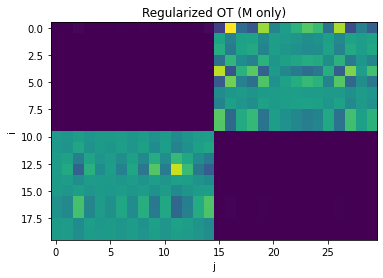

In [12]:
pl.imshow(coupling_ot, cmap='viridis', interpolation='nearest')
pl.title('Regularized OT (M only)')
pl.ylabel('i')
pl.xlabel('j')

pl.show()

# Compute with pure (reg.) Gromov-Wasserstein loss

## POT

\alpha = 1 should correspond to entropically regularized Gromov-Wasserstein. 

In [36]:
coupling_GW, loss_GW = entropic_gromov_wasserstein(C1, C2, p, q, loss_fun='square_loss', 
                                        verbose=True, log=True, epsilon=epsilon)

It.  |Err         
-------------------
    0|4.082483e-02|
   10|0.000000e+00|


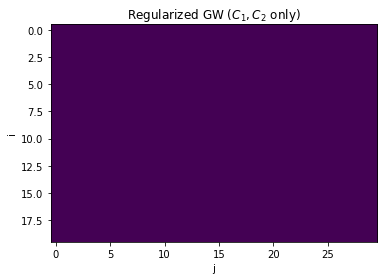

In [37]:
pl.imshow(coupling_GW, cmap='viridis', interpolation='nearest')
pl.title('Regularized GW ($C_1, C_2$ only)')
pl.ylabel('i')
pl.xlabel('j')

pl.show()

## OTT

In [38]:
from ott.core.gromov_wasserstein import gromov_wasserstein
C1_g = Geometry(cost_matrix=jnp.asarray(C1, dtype=jnp.float64))
C2_g = Geometry(cost_matrix=jnp.asarray(C2, dtype=jnp.float64))

In [39]:
GW_object = gromov_wasserstein(C1_g, C2_g, epsilon=2, sinkhorn_kwargs={})

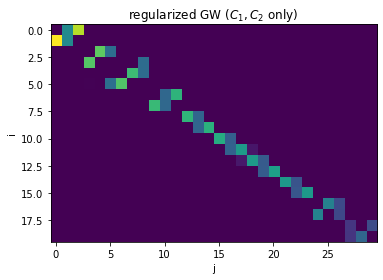

In [40]:
pl.imshow(GW_object.transport, cmap='viridis', interpolation='nearest')
pl.title('regularized GW ($C_1, C_2$ only)')
pl.ylabel('i')
pl.xlabel('j')

pl.show()

# Compare with pure (unreg.) Gromow-Wasserstein

\alpha = 1 should correspond to entropically regularized Gromov-Wasserstein. 

In [41]:
coupling_GW, loss_GW = gromov_wasserstein(C1, C2, p, q, loss_fun='square_loss', 
                                        verbose=True, log=True)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.683978e+04|0.000000e+00|0.000000e+00
    1|3.860061e+04|2.134468e-01|8.239175e+03
    2|2.182948e+04|7.682787e-01|1.677113e+04
    3|2.182948e+04|0.000000e+00|0.000000e+00


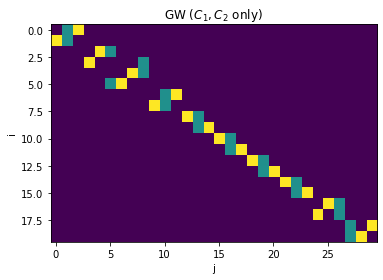

In [42]:
pl.imshow(coupling_GW, cmap='viridis', interpolation='nearest')
pl.title('GW ($C_1, C_2$ only)')
pl.ylabel('i')
pl.xlabel('j')

pl.show()